In [1]:
import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf

# sorrel imports
from sorrel.examples.staghunt.agents import StagHuntAgent
from sorrel.examples.staghunt.entities import Empty, entity_list
from sorrel.examples.staghunt.env import StagHuntEnv
from sorrel.examples.staghunt.world import StagHuntWorld
from sorrel.action.action_spec import ActionSpec
from sorrel.models.human_player import HumanPlayer, HumanObservation

### Human player test for the model

In [2]:
def main():
    config = OmegaConf.load("../configs/config.yaml")
    env = StagHuntWorld(config=config, default_entity=Empty())
    experiment = StagHuntEnv(env, config)
    agents = experiment.agents

    observation_spec = HumanObservation(
        entity_list=entity_list,
        full_view=True,
        env_dims=(config.world.height, config.world.width),
    )
    action_spec = ActionSpec(
        ["NOOP", "FORWARD", "BACKWARD", "STEP_LEFT", "STEP_RIGHT", "TURN_LEFT", "TURN_RIGHT", "INTERACT"]
    )

    # Create a custom HumanPlayer that works with StagHuntAgent
    class StagHuntHumanPlayer(HumanPlayer):
        def __init__(self, input_size, action_space, memory_size):
            super().__init__(input_size, action_space, memory_size)
            # Calculate the expected visual size (without extra features)
            self.visual_size = (
                input_size[0]
                * input_size[1]
                * input_size[2]
                * (self.tile_size**2)
                * self.num_channels
            )
            # The StagHuntAgent will provide visual_size + 3 extra features
            self.total_input_size = self.visual_size + 3

        def take_action(self, state: np.ndarray):
            """Custom take_action that handles StagHuntAgent's extra features."""
            if self.show:
                from IPython.display import clear_output

                clear_output(wait=True)

                # Extract just the visual part (first visual_size elements)
                visual_state = state[:, : self.visual_size]

                # Reshape to image format
                visual_state = visual_state.reshape(
                    (
                        -1,
                        self.input_size[0] * self.tile_size,
                        self.input_size[1] * self.tile_size,
                        self.num_channels,
                    )
                )
                visual_state = np.array(visual_state, dtype=int)
                state_ = []
                for i in range(visual_state.shape[0]):
                    state_.append(visual_state[i, :, :, :])
                from sorrel.utils.visualization import plot

                plot(state_)

            # Get action from user
            action = None
            num_retries = 0
            while not isinstance(action, int):
                action_ = input(
                    "Select Action (w=FORWARD, s=BACKWARD, a=TURN_LEFT, d=TURN_RIGHT, q=STEP_LEFT, e=STEP_RIGHT, space=INTERACT, 0=NOOP): "
                )
                if action_ in ["w", "s", "a", "d", "q", "e", " "]:
                    if action_ == "w":
                        action = 1  # FORWARD (relative to orientation)
                    elif action_ == "s":
                        action = 2  # BACKWARD (relative to orientation)
                    elif action_ == "a":
                        action = 5  # TURN_LEFT
                    elif action_ == "d":
                        action = 6  # TURN_RIGHT
                    elif action_ == "q":
                        action = 3  # STEP_LEFT
                    elif action_ == "e":
                        action = 4  # STEP_RIGHT
                    elif action_ == " ":
                        action = 7  # INTERACT
                elif action_ in [str(act) for act in self.action_list]:
                    action = int(action_)
                elif action_ == "0":
                    action = 0  # NOOP
                elif action_ == "quit":
                    raise KeyboardInterrupt("Quitting...")
                else:
                    num_retries += 1
                    if num_retries > 5:
                        raise KeyboardInterrupt("Too many invalid inputs. Quitting...")
                    print("Please try again. Possible actions are below.")
                    print("Keys: w=FORWARD, s=BACKWARD, a=TURN_LEFT, d=TURN_RIGHT, q=STEP_LEFT, e=STEP_RIGHT, space=INTERACT, 0=NOOP")
                    print("Or enter action number (0-7) or 'quit'")

            return action

    # Create a custom StagHuntAgent that bypasses the memory stacking issue
    class StagHuntHumanAgent(StagHuntAgent):
        def get_action(self, state: np.ndarray) -> int:
            """Override get_action to bypass memory stacking for human player."""
            # For human player, we don't need memory stacking
            # Just pass the state directly to the model
            action = self.model.take_action(state)
            return action

        def add_memory(
            self, state: np.ndarray, action: int, reward: float, done: bool
        ) -> None:
            """Override add_memory to handle dimension mismatch for human player."""
            # For human player, we don't need to store experiences in memory
            # The human player doesn't learn from experience, so we can skip this
            pass

    human_player1 = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            3,
        ),  # 2 layers: bottom and top
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    human_player2 = StagHuntHumanPlayer(
        input_size=(
            config.world.height,
            config.world.width,
            3,
        ),  # 2 layers: bottom and top
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    agent1 = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player1,
    )

    agent2 = StagHuntAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player2,
    )

    experiment.override_agents(agents=[agent1])  # Use single human agent
    experiment.run_experiment()

### Turn taking loop
Choose an action from [0, 1, 2, 3, 4, 5] to act on the environment.

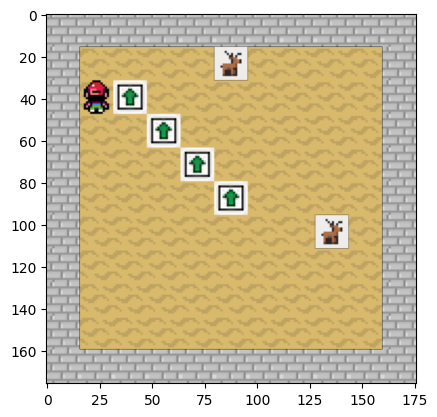

KeyboardInterrupt: Quitting...

In [3]:
main()